# Data Exploration

## Imports

In [1]:
import pandas as pd
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline

## Import Files

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/FullDF.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,Nieuwmarkt Lat,Nieuwmarkt Lon,Nieuwezijds Kolk Lat,Nieuwezijds Kolk Lon,Dam Lat,Dam Lon,Spui Lat,Spui Lon,...,Nieuwmarkt LatScaled,Nieuwmarkt LonScaled,Nieuwezijds Kolk LatScaled,Nieuwezijds Kolk LonScaled,Dam LatScaled,Dam LonScaled,Spui LatScaled,Spui LonScaled,Centraal Station LatScaled,Centraal Station LonScaled
0,2018-03-11,2400,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.053591,0.075412,0.055127,0.047017,0.05401,0.03321,0.052585,0.030104,0.055554,0.073682
1,2018-03-11,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.053591,0.075412,0.055127,0.047017,0.05401,0.03321,0.052585,0.030104,0.055554,0.073682
2,2018-03-11,2100,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.053591,0.075412,0.055127,0.047017,0.05401,0.03321,0.052585,0.030104,0.055554,0.073682
3,2018-03-11,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.053591,0.075412,0.055127,0.047017,0.05401,0.03321,0.052585,0.030104,0.055554,0.073682
4,2018-03-11,2200,52.371942,4.901239,52.376288,4.893731,52.373127,4.89008,52.369097,4.889259,...,0.053591,0.075412,0.055127,0.047017,0.05401,0.03321,0.052585,0.030104,0.055554,0.073682


## GVB
This dataset contains passenger data from the tram and metro within Amsterdam. The plots below shows the average passenger counts for each day of the week, per station. Just to show how busy each station is on average

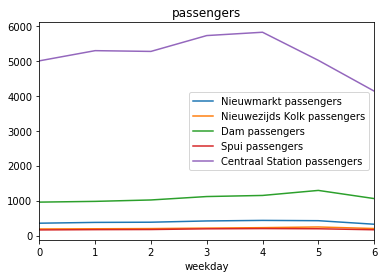

In [3]:
stations = ["Nieuwmarkt", "Nieuwezijds Kolk", "Dam", "Spui", "Centraal Station"]

for station in stations:
    full_df[station + " passengers"] = full_df[station +" score"] / full_df[station +" weight"]

df = full_df[["weekday", "Nieuwmarkt passengers", "Nieuwezijds Kolk passengers", "Dam passengers",
             "Spui passengers", "Centraal Station passengers"]].groupby(["weekday"]).agg(
            {"Nieuwmarkt passengers": "mean", 
             "Nieuwezijds Kolk passengers": "mean", 
             "Dam passengers": "mean",
             "Spui passengers": "mean", 
             "Centraal Station passengers": "mean"}).reset_index()

df.plot(x="weekday", title="passengers")
plt.savefig('../../../Data_thesis/Useful/passenger_counts.png')

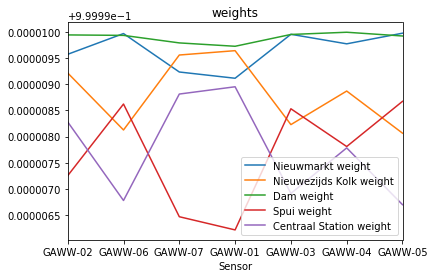

In [4]:
df = full_df[["Sensor", "Nieuwmarkt weight", "Nieuwezijds Kolk weight", "Dam weight",
             "Spui weight", "Centraal Station weight"]].copy()
df.drop_duplicates(subset=["Sensor"], inplace=True)

df.plot(x="Sensor", title="weights")
plt.savefig('../../../Data_thesis/Useful/station_weights.png')

## CMSA 
This dataset contains the sensor data the models will predict. The plot below shows the average crowdedness counts per sensor for each day of the week. This shows what the most busy places of Amsterdam are

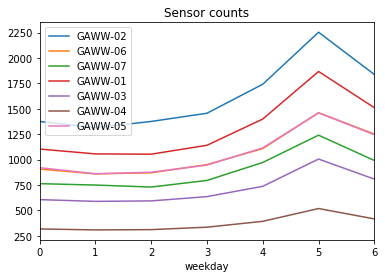

In [5]:
df_dict = {}

for sensor in full_df["Sensor"].unique():
    df = full_df[full_df["Sensor"] == sensor][["Sensor", "CrowdednessCount", 
                                                       "weekday"]].groupby(["Sensor", "weekday"]).agg(
        {"CrowdednessCount": "mean"}).reset_index()
    temp_dict = df.to_dict(orient="index")
    CrowdednessCount_list = []
    weekday_list = []
    for k,v in temp_dict.items():
        weekday_list.append(v["weekday"])
        CrowdednessCount_list.append(v["CrowdednessCount"])
    
    if "weekday" not in df_dict:
        df_dict["weekday"] = weekday_list
        
    df_dict[v["Sensor"]] = CrowdednessCount_list
    

df = pd.DataFrame.from_dict(df_dict)

df.plot(x="weekday", title="Sensor counts")
plt.savefig('../../../Data_thesis/Useful/sensor_counts.png')

## Map
The locations of all the sensors and stations are mapped below. This shows that all the sensors are placed within the same are (Red Light District) and that the stations are scattered around more. 

In [6]:
street_map = gpd.read_file("../../../Data_thesis/MapShapeFiles/roads.shp")
crs = {"init": "epsg:4326"}

In [7]:
gvb_cor_dict = {}

gvb_dict = full_df.to_dict("index")

gvb_cor_dict["Nieuwmarkt"] = {"Latitude": gvb_dict[0]["Nieuwmarkt Lat"], "Longitude": gvb_dict[0]["Nieuwmarkt Lon"]}
gvb_cor_dict["Nieuwezijdse Kolk"] = {"Latitude": gvb_dict[0]["Nieuwezijds Kolk Lat"], 
                                         "Longitude": gvb_dict[0]["Nieuwezijds Kolk Lon"]}
gvb_cor_dict["Dam"] = {"Latitude": gvb_dict[0]["Dam Lat"], "Longitude": gvb_dict[0]["Dam Lon"]}
gvb_cor_dict["Spui"] = {"Latitude": gvb_dict[0]["Spui Lat"], "Longitude": gvb_dict[0]["Spui Lon"]}
gvb_cor_dict["Centraal Station"] = {"Latitude": gvb_dict[0]["Centraal Station Lat"], "Longitude": gvb_dict[0]["Centraal Station Lon"]}

gvb_cor_df = pd.DataFrame.from_dict(gvb_cor_dict, orient="index").reset_index()
gvb_cor_df = gvb_cor_df.rename(index=str, columns={"index": "Station"})

In [8]:
sensor_geometry = [Point(xy) for xy in zip(full_df["SensorLongitude"], full_df["SensorLatitude"])]
gvb_geometry = [Point(xy) for xy in zip(gvb_cor_df["Longitude"], gvb_cor_df["Latitude"])]

In [9]:
sensor_geo_df = gpd.GeoDataFrame(full_df, crs = crs,geometry = sensor_geometry)
sensor_geo_df = sensor_geo_df[["Sensor", "geometry"]]

gvb_geo_df = gpd.GeoDataFrame(gvb_cor_df, crs = crs,geometry = gvb_geometry)
gvb_geo_df = gvb_geo_df[["Station", "geometry"]]

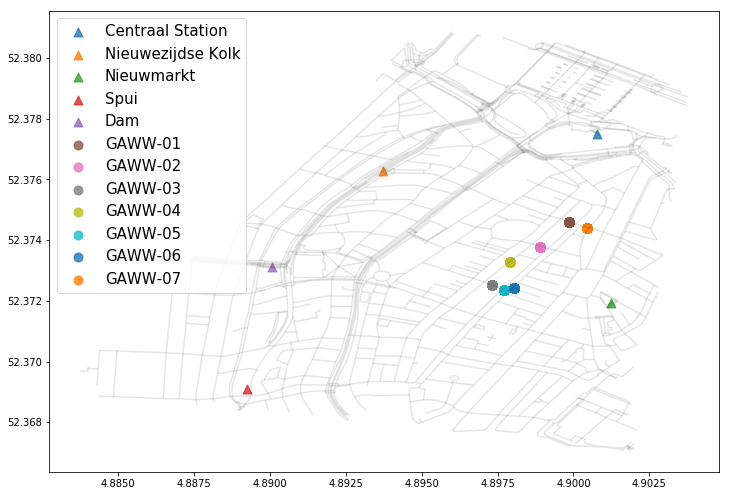

In [10]:
fig,ax = plt.subplots(figsize = (12, 12))
street_map.plot(ax = ax, alpha = 0.1, color = "black")

gvb_geo_df[gvb_geo_df["Station"] == "Centraal Station"].plot(ax = ax, markersize = 80, marker = "^", 
                                                        label = "Centraal Station", alpha = 0.8)
gvb_geo_df[gvb_geo_df["Station"] == "Nieuwezijdse Kolk"].plot(ax = ax, markersize = 80, marker = "^", 
                                                        label = "Nieuwezijdse Kolk", alpha = 0.8)
gvb_geo_df[gvb_geo_df["Station"] == "Nieuwmarkt"].plot(ax = ax, markersize = 80, marker = "^", 
                                                        label = "Nieuwmarkt", alpha = 0.8)
gvb_geo_df[gvb_geo_df["Station"] == "Spui"].plot(ax = ax, markersize = 80, marker = "^", 
                                                        label = "Spui", alpha = 0.8)
gvb_geo_df[gvb_geo_df["Station"] == "Dam"].plot(ax = ax, markersize = 80, marker = "^", 
                                                        label = "Dam", alpha = 0.8)

sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-01"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-01", alpha = 0.8)
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-02"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-02", alpha = 0.8)
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-03"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-03", alpha = 0.8)
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-04"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-04", alpha = 0.8)
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-05"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-05", alpha = 0.8)
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-06"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-06", alpha = 0.8)
sensor_geo_df[sensor_geo_df["Sensor"] == "GAWW-07"].plot(ax = ax, markersize = 80, marker = "o", 
                                                       label = "GAWW-07", alpha = 0.8)

plt.legend(prop={"size": 15})
plt.savefig('../../../Data_thesis/Useful/map.png')